# Wave Equation

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from firedrake import *
import matplotlib.pyplot as plt

In [2]:
dim = 1
order = 1

if dim == 1:
    N = 512
    M = 512*8
    tau = 1/512/32
    # mesh = IntervalMesh(N, -1, 1)
    mesh = PeriodicIntervalMesh(N, 2)
elif dim == 2:
    N = 128
    M = 128*8
    tau = 1/128/32
    mesh = PeriodicRectangleMesh(N, N, 1, 1)
else:
    raise NotImplementedError

In [3]:
V = FunctionSpace(mesh, "CG", order)
u, v = TrialFunction(V), TestFunction(V)

u_n = Function(V, name='u_n')
v_n = Function(V, name='v_n')

u_np1 = Function(V, name='u_np1') # u^{n+1)
v_np1 = Function(V, name='v_np1') # u^{n+1)
v_h = Function(V, name='v_h') # v^{n+1/2}

a = u*v*dx + tau**2/4*dot(grad(u), grad(v))*dx - v_n*v*dx + tau/2*dot(grad(u_n), grad(v))*dx
bc = None # DirichletBC(V, 0, 'on_boundary')
problem = LinearVariationalProblem(lhs(a), rhs(a), v_h, bcs=bc)
solver = LinearVariationalSolver(problem)

In [4]:
x = SpatialCoordinate(mesh)                          
if len(x) == 1:
    u_0 = conditional(And(x[0] > 0.25, x[0] < 0.75), 1, 0)
elif len(x) == 2:
    u_0 = conditional(And(And(x[0] > 0.25, x[0] < 0.75),
                          And(x[1] > 0.25, x[1] < 0.75)),
                      1, 0)
else:
    raise NotImplementedError
    
u_n.interpolate(u_0)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x30880fe60>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 6)), 12)

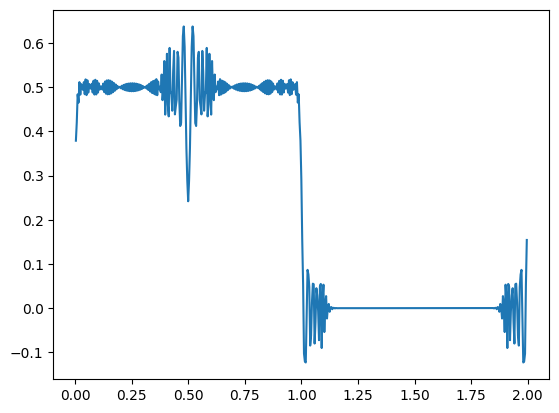

In [9]:
if dim == 1:
    V_coords = VectorFunctionSpace(mesh, u_n.function_space().ufl_element())
    coords = Function(V_coords).interpolate(mesh.coordinates)
    ret = plt.plot(coords.dat.data[1:], u_n.dat.data[1:])

In [6]:
# output = VTKFile(f'data/solution_p{order}.pvd')
# output.write(u_n, v_n, time=0)

for i in range(M):
    solver.solve()
    u_np1.assign(u_n + tau*v_h)
    v_np1.assign(2*v_h - v_n)

    u_n.assign(u_np1)
    v_n.assign(v_np1)
    # if (i+1)%32 == 0:
    #     output.write(u_n, v_n, time=i*tau)

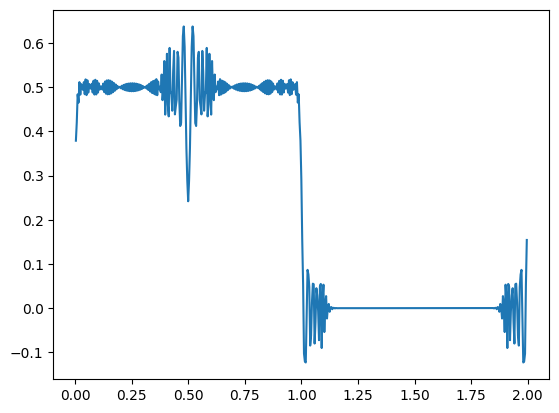

In [10]:
if dim == 1:
    ret = plt.plot(coords.dat.data[1:], u_n.dat.data[1:])